# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1239]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [3057]:
sigma = 0.12
n_reps = 5
true_bohr = np.linspace(-10, 10, 10)
dataset_fc = []
fc_mu = (1 + np.exp(-true_bohr))**-1
fc_mut = (1 + np.exp(-true_bohr * 0.8))**-1
for i, b in enumerate(true_bohr):
    mu = fc_mut[i]
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

In [3058]:
# Load the stan model
model = mut.bayes.StanModel('../stan/empirical_F.stan' ) #, force_compile=True)
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=5000, control=dict(adapt_delta=0.99))
    
    # Correct past extrema
    extrema_idx = (samples['fc_mu'] <= samples['fc_sigma']).astype(int) +\
                    (1 - samples['fc_mu'] <= samples['fc_sigma']).astype(int)
    
    dF_dfc = (samples['fc_mu'] - samples['fc_mu']**2)**-1
    corr = np.sign(g) * (samples['fc_sigma'] - samples['fc_sigma']**2) - (np.exp(-g)/(1 + np.exp(-g))**2) 
    samples['corr'] = corr * dF_dfc *extrema_idx
    samples['delta_bohr'] -= samples['corr']
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'empirical_bohr',
                                                            'delta_bohr', 'corr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stats['fc_mu_std'] = np.std(samples['fc_mu'])
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

Found precompiled model. Loading...
finished!


/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


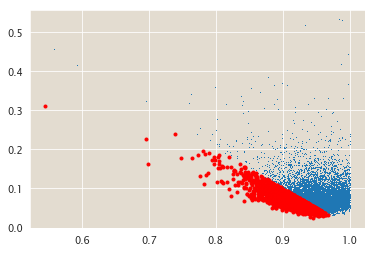

In [3063]:
samples['idx'] = (samples['fc_mu'] < samples['fc_sigma']) + (1-samples['fc_mu'] > samples['fc_sigma'])
plt.plot(samples['fc_mu'], samples['fc_sigma'], ',')
plt.plot(samples[samples['idx']==1]['fc_mu'], samples[samples['idx']==1]['fc_sigma'], '.',
        color='red')



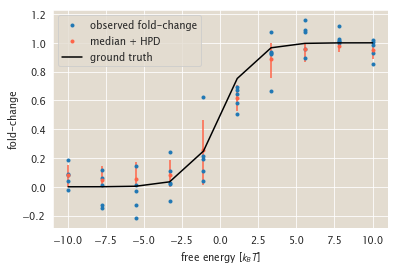

In [3064]:
_fc_mu = stats[stats['parameter']=='fc_mu']
plt.plot(dataset['true_bohr'], dataset['fold_change'], '.', label='observed fold-change')
plt.plot(_fc_mu['true_bohr'], _fc_mu['mean'], '.', color='tomato', label='median + HPD' )
plt.vlines(_fc_mu['true_bohr'], _fc_mu['hpd_min'], _fc_mu['hpd_max'], color='tomato', label='__nolegend__')
plt.plot(true_bohr, (1 + np.exp(-true_bohr))**-1, 'k-', label='ground truth')
plt.xlabel('free energy [$k_BT$]')
plt.ylabel('fold-change')
plt.legend()

(-10, 10)

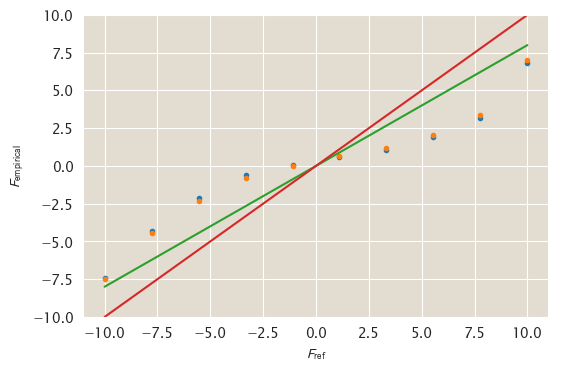

In [3068]:
plt.figure(dpi=100)
dbohr = stats[stats['parameter']=='delta_bohr']
bohr = stats[stats['parameter']=='empirical_bohr']
_sigma = stats[stats['parameter']=='fc_sigma']['median'].values
_fc_mu = stats[stats['parameter']=='fc_mu']['median'].values
corr_bohr = stats[stats['parameter']=='corr']
sig = sigma * np.ones(len(true_bohr))

# Compute the error from the true bohr with bounds. 
bohr_sigma_high = -np.log((1/(_sigma)) -1)
bohr_sigma_low = -np.log((1/(_sigma)) -1)
# low_end =  bohr_sigma_low
high_end =  bohr_sigma_low


# extrema_idx = np.ones(len(true_bohr)) * ((_fc_mu < _sigma) + (1-_fc_mu < sigma))
plt.plot(true_bohr,true_bohr - bohr['mean'], '.')
plt.plot(true_bohr,true_bohr - bohr['median'], '.')
# plt.plot(true_bohr, bohr['median'] + low_end - high_end, 'o')
# plt.plot(true_bohr, low_end)
plt.plot(true_bohr, true_bohr * 0.8)
plt.plot(true_bohr, true_bohr )

plt.plot()
plt.xlabel('$F_\mathrm{ref}$')
plt.ylabel('$F_\mathrm{empirical}$')
plt.ylim([-10, 10])

In [3056]:
extrema_idx

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      2
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
9970    1
9971    1
9972    1
9973    1
9974    1
9975    1
9976    1
9977    1
9978    1
9979    1
9980    1
9981    1
9982    1
9983    1
9984    1
9985    1
9986    1
9987    1
9988    1
9989    1
9990    1
9991    1
9992    1
9993    1
9994    1
9995    1
9996    1
9997    1
9998    1
9999    1
Length: 10000, dtype: int64

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])